<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Introduction to the LSST deblender data products</b> <br>
Contact author(s): <i>Christina WIlliams</i> <br>
Last verified to run: <i>2023-02-24</i> <br>
LSST Science Piplines version: Weekly <i>2023_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

**Description:**  Introduce the data products created by the LSST multiband deblender (Scarlet; Melchior et al. 2018; https://ui.adsabs.harvard.edu/abs/2018A%26C....24..129M/abstract) and illustrate some simple use cases for the deblender products that are stored after the pipeline is run. 

**Skills:** Learn the use cases of deblender products and keywords in LSST catalogs through visual demonstration and explanation of the keywords

**LSST Data Products:** Images (deepCoadd, skyMap, MaskedImage) and Catalogs (objectTable)

**Packages:** lsst.afw.image, lsst.afw.detection, lsst.rsp, lsst.daf.butler, lsst.geom, astropy, numpy, 

**Credit:** Developed by Christina Willliams in collaboration with Melissa Graham and the Rubin Community Engagement Team for DP0.2. Influenced by StackClub notebooks demonstrating how to run the LSST deblender (Scarlet; Melchior et al. 2018) by Fred Moolekamp and Alex Drlica-Wagner. 

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook is an introduction to the data products that are created by the LSST pipeline deblender. In order to build its source catalog and measure photometry of objects in images, the LSST pipeline uses a multi-wavelength deblending algorithm (Scarlet, Melchior et al. 2018) to identify independent detected components within source blends, and separate the flux from independent objects. A "parent" source is identified as a region of connected pixels above Signal to Noise (S/N) of XX in the deepCoadd. These regions are called footprints. Each footprint may have one or more peaks, and it is these peaks that the deblender will use to infer the number and positions of objects blended in each footprint. The de-blended sub-peaks are referred to as "children" of the parent in the properties saved by the deblender in the objectTable.

Scarlet separates the flux among components by modeling the flux and shape of each source making up the blend.

As an example, in this tutorial we will identify a heavily blended source with many components, and explore how to use the information in the objectTable produced by the deblender to identify the indepedent sources within the blend. The keywords for sources identified by the deblender should be used to identify unique sources in the objectTable. We will also show an example of how to access metadata that is attached to each deblended source in the objectTable (e.g. the deblended footprints and pixel-weight maps).

An introduction to all of the available deblending flags, and the processes that produce the deblender data products discussed here can be found here:
https://pipelines.lsst.io/modules/lsst.pipe.tasks/deblending-flags-overview.html

A general discussion of blending impacts to LSST can be found in Melchior et al. 2021: https://lss.fnal.gov/archive/2021/pub/fermilab-pub-21-598-ppd.pdf

Some more in depth presentations on the deblending implementation in the LSST pipeline are available from recorded talks during the Rubin PCW 2022: https://project.lsst.org/meetings/rubin2022/agenda/deblending-plans-and-challenges

### 1.1 Package Imports

The [`matplotlib`](https://matplotlib.org/), [`numpy`](http://www.numpy.org/), and [`astropy`](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, and astronomical data analysis. We will use these packages below, including the `matplotlib.pyplot` plotting sublibrary.

the `lsst.rsp` package to access the TAP service and query the DP0 catalogs.

Here we will use the `lsst.afw.image` and `lsst.afw.detection` packages to access some of the extended products created by the deblender pipeline. 

We will also use previously introduced packages including the `lsst.afw.display` library to gain access to the image visualization routines we'd like to use, and the `lsst.daf.butler` library, which is used to access data products.

In [1]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
import time
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service, retrieve_query

# LSST package for Butler queries
import lsst.daf.butler as Butler

# Familiar stack packages
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
from lsst.afw.image import Exposure, Image

# LSST package for image display
import lsst.afw.display as afwDisplay
import lsst.geom as geom
afwDisplay.setDefaultBackend('matplotlib')

# Packages for dealing with multi-band data products
from lsst.afw.image import MultibandExposure, MultibandImage
from lsst.afw.detection import MultibandFootprint, Footprint

# For the heavyFootprint2Image function
from lsst.afw.image import MaskedImage

# Astropy imports
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.visualization import make_lupton_rgb
from astropy.nddata import Cutout2D

### 1.2 Define Functions and Parameters for the image plots 

Here we define default parameters for plotting, and define two functions to help us visualize deblended products: 1) cutout_coadd will make an image cutout (see tutorial notebook 03a) and 2) heavyFootprint2Image will help us grab the "footprint" of deblended objects for further analysis. 



In [2]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

# A function and settings to plot a cutout from tutorial notebook 03a


def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    print("bbox = ", bbox, "xy = ", xy, "cutoutSize = ", cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

# A function to image the footprint of deblended sources from deblender
# products metadata:


def heavyFootprint2Image(heavy, fill=np.nan, bbox=None, imageType=MaskedImage):
    """Create an image of a HeavyFootprint
    Written by Fred Moolekamp
    Parameters
    ----------
    heavy : `HeavyFootprint`
        The HeavyFootprint to insert into the image
    fill: number
        Number to fill the pixels in the image that are not
        contained in `heavy`.
    bbox : `Box2I`
        Bounding box of the output image.
    imageType : `type`
        This should be either a `MaskedImage` or `Image` and describes
        the type of the output image.
    Returns
    -------
    image : `lsst.afw.image.MaskedImage` or `lsst.afw.image.Image`
        An image defined by `bbox` and padded with `fill` that
        contains the projected flux in `heavy`.
    """
    if bbox is None:
        bbox = heavy.getBBox()
    image = imageType(bbox, dtype=heavy.getImageArray().dtype)
    image.set(fill)
    heavy.insert(image)
    return image

## 2. Explore the deblender data products stored in objectTable




The pipeline records a number of keywords that can be used to identify and characterize blended sources (parents) that have been deblended into child sources, both of which are ultimately stored in the object and source tables along with isolated single objects that do not require deblending. These keywords help the user identify a unique sample and avoid double counting of objects in queries. In this tutorial we will focus on the objectTable based on the deepCoadd images. Some example boolean flags set by the deblender that are found in the objectTable:

**detect_isPrimary**: 	True if source has no children, is in inner region of a coadd patch and is in the inner region of a coadd tract, (and is therefore a unique object in the catalog). Note that an object where **detect_isPrimary=True** can still be a deblended child, but itself was not a parent that was separated by the deblender. **To avoid double-counting sources in any selection or query (from including both the parent blend and the nearest child source, or due to including the overlapping area from two or more visits) it is important to set this flag to True.**

**detect_fromBlend**: 	This source is deblended from a parent with more than one child.

**detect_isIsolated**: 	This source was not contained in a blend (source has a single peak, **deblend_nPeaks=True** or its parent only had a single peak **deblend_parentNPeaks=True**). 

**detect_isDeblendedSource**: 	True if source has no children, is in the inner regions of its coadd patch and tract (will be unique) and is either an unblended isolated source or a deblended child from a parent. This is similar to the **detect_isDeblendedModelSource** flag, which is True if source has no children and is a deblended child (but this flag is false for unblended isolated sources).
 
**deblend_skipped**: 	Deblender skipped this source


Some keywords that are set by the deblender that can be used to characterize the blend/deblended sources contained in the objectTable include:

**parentObjectId**: 	Unique ID of parent source. 

**deblend_nPeaks**: 	Number of peaks contained in the parent blend's footprint (=1 for isolated sources)

**deblend_nChild**: 	Number of peaks deblended from the parent (differs from deblend_nPeaks in that nChild excludes both isolated sources, and child peaks that were culled during deblending)

**footprintArea**:  	Number of pixels in the sources detection "footprint". The footprint is a boolean mask of pixels in the input image that were detected as part of the parent blend. This corresponds to the footprint for the "reference band".

**refBand**:  	Filter that the deblender identified the "best" location for the centroid of the peak flux based on the multi-wavelength deblending routine (referred to as the "reference filter").


### 2.1 Access and print the keywords created by the deblender in objectTable

In this tutorial we will explore use cases for a few of these keywords in the objectTable. These can be accessed via TAP queries, or through the butler, so we will demonstrate both. First, lets open a TAP service and initialize a Butler instance:


In [3]:
# open TAP service
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

# initialize Butler
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler.Butler(config, collections=collection)




In theory, one can search the LSST data for objects with certain characteristics, such as by how many sources are blended together. However, when searching either through TAP queries or using the butler, one must first identify the region of the sky to search and search in a specific region defined by RA/Dec within a certain search radius or patch/tract. This is because the databases are indexed by RA/Dec and searching by blending keywords (i.e. to identify the most blended sources or by parent object ID) are extremely inefficient. The reason that Qserv is spatially sharded, so querying by RA/Dec is always going to be more efficient than querying by butler dimensions such as patch, tract, etc. RA/Dec is the way to go to optimize TAP queries. (For more information, see tutorial notebook 02 on TAP queries, and notebook 04a on introduction to the Butler).

However, we show an example below. Note that uncommenting the cell will run a query that takes approximately 15 minutes.

In [4]:
# %%time

# Use TAP service to search for very blended sources.
# This is very slow (run time approx 15 min). TAP is optimized to
# search on RA / Dec, not other keywords, so ideally one should not use this
# method. But, we include it for demonstration purposes. We show a better
# method below.

# query = "SELECT TOP 10 objectId, x, y, coord_ra, coord_dec, " + \
#        detect_isPrimary, deblend_nChild, deblend_skipped," + \
#        "detect_fromBlend, detect_isDeblendedModelSource,  " + \
#        "detect_isDeblendedSource, detect_isIsolated, parentObjectId, " + \
#        "footprintArea, z_blendedness, tract, patch " + \
#        "FROM dp02_dc2_catalogs.Object " + \
#        "WHERE deblend_nChild > 12 AND  detect_fromBlend = 1 "

# Convert the results to an Astropy table then look at it
# tab_maxblend = results_maxblend.to_table()
# tab_maxblend

Instead, if you can identify a region of the sky first and then perform the search, retrieving examples of heavily blended sources with the query is much faster. Here we have already identified an RA/Dec region with a few examples of heavily blended sources (using the long search above) as input to demonstrate the deblended data products produced by the pipeline in the rest of the tutorial:

In [5]:
# This ra/dec was identified by running the query above to search for blends
# of more than 12 children.

ra = 50.1089143
dec = -44.4812763

query = "SELECT ObjectId, x, y, coord_ra, coord_dec, detect_isPrimary, " + \
        "deblend_nChild, deblend_skipped, detect_fromBlend,  " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, " +\
        "detect_isIsolated, parentObjectId, footprintArea, z_blendedness, " + \
        "tract, patch " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", 0.005)) = 1 "

results = service.search(query, maxrec=1000)
table = results.to_table()

# print the output from this query, and a selection of deblender keywords
table

ObjectId,x,y,coord_ra,coord_dec,detect_isPrimary,deblend_nChild,deblend_skipped,detect_fromBlend,detect_isDeblendedModelSource,detect_isDeblendedSource,detect_isIsolated,parentObjectId,footprintArea,z_blendedness,tract,patch
,pix,pix,deg,deg,,,,,,,,,pix,,,
int64,float64,float64,float64,float64,bool,int32,bool,bool,bool,bool,bool,int64,int32,float64,int64,int64
1248675773246610542,23484.4969535,3210.1552014,50.1089143,-44.4812763,False,13,False,False,False,False,False,0,3435,0.0,2897,5
1248675773246610547,23563.5752424,3231.8072968,50.1027731,-44.4800338,False,2,False,False,False,False,False,0,527,0.0,2897,5
1248675773246610553,23524.8643399,3227.0075054,50.1057834,-44.4803199,True,1,False,False,False,True,True,0,58,--,2897,5
1248675773246610464,23416.9067072,3207.6626404,50.1141746,-44.4814485,False,4,False,False,False,False,False,0,442,--,2897,5
1248675773246610465,23556.0969913,3181.0920143,50.1033197,-44.4828545,False,2,False,False,False,False,False,0,419,--,2897,5
1248675773246610670,23512.1110001,3294.8510731,50.1068235,-44.476558,False,12,False,False,False,False,False,0,4757,0.0,2897,5
1248675773246610610,23442.6545984,3248.4650418,50.1121983,-44.4791693,True,1,False,False,False,True,True,0,64,--,2897,5
1248675773246610640,23553.8117286,3263.4481399,50.1035553,-44.4782812,True,1,False,False,False,True,True,0,102,0.0033508,2897,5


### 2.2 Displaying a heavily blended source in the LSST data

Lets take the first entry above, which is a "parent" source (it has **detect_isPrimary=False** indicating it is not a primary source, i.e. is the blended parent) that is composed of 13 blended children (i.e. **deblend_nChild = 13**). Perhaps counterintuitively, the parent is identified by **detect_isPrimary = False**, which is a keyword that should be used for identifying unique detections in the objectTable (i.e. **detect_isPrimary = True** are the deblended objects that are also detected in the center of their tracts, i.e. do not also appear in another overlapping image). When selecting samples it is important to ensure **detect_isPrimary = True** to prevent double counting of objects. 

In [6]:
# set our selected "parent" blend of 13 sources to be the first return of the
# TAP query above.
sel_objid = table['ObjectId'][0]
x = table['x'][0]
y = table['y'][0]
tract = table['tract'][0]
patch = table['patch'][0]

# Isolate the deblended components of the object using the parentObjectId
whchild = np.where(table['parentObjectId'] == sel_objid)[0]
print(len(whchild), "sources deblended from parentObjectId", sel_objid)


13 sources deblended from parentObjectId 1248675773246610542


The above cell demonstrates identifying the blend using the TAP query from Section 2.1, but we can return the same sources and properties using the Butler. We demonstrate the equivalent Butler query below:

In [7]:
%%time
# Next, demonstrate how to retrieve the same heavily blended sources using the Butler

dataId = {'tract': tract, 'band': 'i', 'patch': patch }

obj = butler.get('objectTable',  dataId) #tract=tract, patch=patch)
print(f"Retrieved catalog of {len(obj)} objects.")

obj_parentObjectId = np.asarray(obj.parentObjectId, dtype='int')
obj_objectId = np.asarray(obj.index, dtype='int')
obj_coord_x = np.asarray(obj.x, dtype='float')
obj_coord_y = np.asarray(obj.y, dtype='float')
obj_ra = np.asarray(obj.coord_ra, dtype='float') 
obj_dec = np.asarray(obj.coord_dec, dtype='float')

# Pull out all of the sources that are blended with our chosen source as the parent
wh = np.where(obj_parentObjectId == sel_objid )[0]
for i in wh:
    print(obj_parentObjectId[i], obj_objectId[i], obj_coord_x[i], obj_coord_y[i])
print('FOUND', len(wh), "sources blended with Parent ID sel_objid")


Retrieved catalog of 32101 objects.
1248675773246610542 1248675773246640703 23484.493982278047 3210.1595244834843
1248675773246610542 1248675773246640704 23466.9451451522 3233.6287998058606
1248675773246610542 1248675773246640705 23483.320008254163 3246.0487119002632
1248675773246610542 1248675773246640706 23512.9343388915 3205.7072499403953
1248675773246610542 1248675773246640707 23455.400666064994 3242.1856875225335
1248675773246610542 1248675773246640708 23488.07512761676 3231.692096689908
1248675773246610542 1248675773246640709 23459.093178291714 3230.9886405112957
1248675773246610542 1248675773246640710 23495.101275324098 3184.438564042999
1248675773246610542 1248675773246640711 23502.63552370019 3188.5572090849855
1248675773246610542 1248675773246640712 23465.71870790558 3197.3916488116315
1248675773246610542 1248675773246640713 23478.921981330524 3227.3238198632953
1248675773246610542 1248675773246640714 23503.206784555066 3201.591832926169
1248675773246610542 124867577324664071


## 2.3 Displaying an example of a heavily blended source

bbox =  (minimum=(23384, 3110), maximum=(23584, 3310)) xy =  (23484, 3210) cutoutSize =  (201, 201)
0 23512.9343389 3205.7072499
1 23483.3200083 3246.0487119
2 23466.9451452 3233.6287998
3 23484.4939823 3210.1595245
4 23463.0054624 3244.5699979
5 23503.2067846 3201.5918329
6 23478.9219813 3227.3238199
7 23465.7187079 3197.3916488
8 23502.6355237 3188.5572091
9 23495.1012753 3184.438564
10 23459.0931783 3230.9886405
11 23488.0751276 3231.6920967
12 23455.4006661 3242.1856875


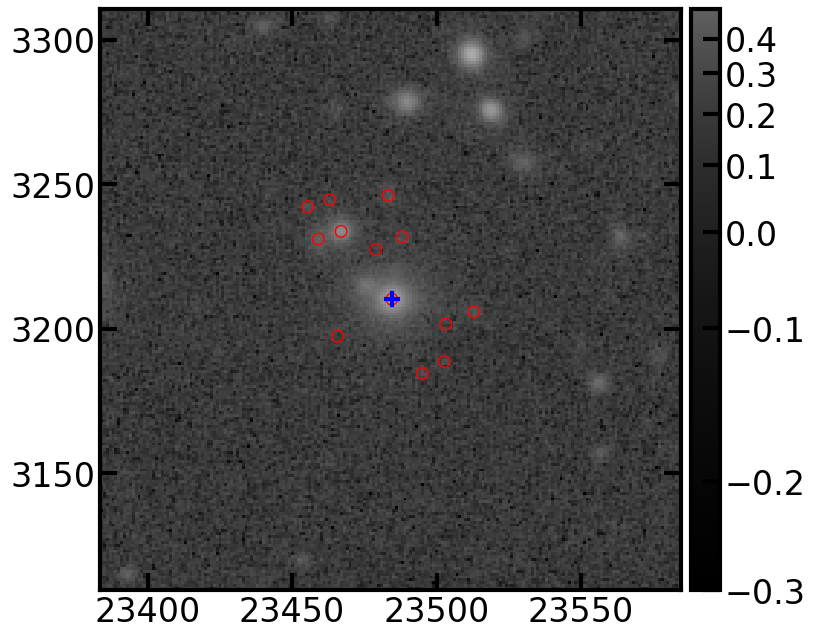

In [8]:
# Use the cutout function from tutorial notebook 03:
cutout_image = cutout_coadd(butler, ra, dec, band='i', datasetType='deepCoadd',
                            cutoutSideLength=201)

wcs = cutout_image.getWcs()

x0 = float(cutout_image.getX0())
y0 = float(cutout_image.getY0())
width = cutout_image.getWidth()
height = cutout_image.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())


fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)

with display.Buffering():
    for i in range(len(table[whchild])):
        display.dot('o', table[whchild][i]['x'], table[whchild][i]['y'],
                    ctype=afwDisplay.RED)
        print(i, table[whchild][i]['x'], table[whchild][i]['y'])
display.dot('+', x, y, ctype=afwDisplay.BLUE)
plt.show()



## 3. Access the deblender data products metadata




#### What other deblender results are available in the butler?

Scarlet (as part of the LSST pipeline) produces the deepCoadd_deblendedFlux data product (among other output catalogs) after using the multiwavelength colors to identify peaks. Here we search for these intermediate-stage data products with the word "blend" in the title to see what is accessible via the Butler. We will explore a primary one, **deepCoadd_deblendedFlux** later in Section 3.1.

In [9]:
registry = butler.registry
for dt in sorted(registry.queryDatasetTypes('*blend*')):
    print(dt)

DatasetType('deblend_config', {}, Config)
DatasetType('deblend_log', {skymap, tract, patch}, ButlerLogRecords)
DatasetType('deblend_metadata', {skymap, tract, patch}, PropertySet)
DatasetType('deepCoadd_deblendedFlux', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_deblendedFlux_schema', {}, SourceCatalog)
DatasetType('deepCoadd_deblendedModel', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_deblendedModel_schema', {}, SourceCatalog)
DatasetType('deepCoadd_mcalmax_deblended', {skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_mcalmax_deblended_schema', {}, SourceCatalog)
DatasetType('deepCoadd_ngmix_deblended', {skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_ngmix_deblended_schema', {}, SourceCatalog)


### 3.1 What information is stored in the butler by the deblending pipeline? 

The various deblender tasks (source detection across filters for a merged set of flux peaks and forced photometry on those peaks, etc) will produce a number of tables that are accessible via the butler. Let's look at contents of a few of them:

**deepCoadd_det:** catalog of detections in each filter that are merged to create list of multi-wavelength peaks across all filters. Only used as input for next stage of deblender.

**deepCoadd_mergedet:** consistent table of sources across filters

**deepCoadd_deblendedFlux:** using the list of peaks in all of the filters this table contains the deblended flux

**deepCoadd_meas:** Using the "best" position for each flux peak (using information available from all filters) this table contains the forced photometry (i.e. at the position of the peak using the "best" filter, referred to as the "reference filter")

**deepCoadd_ref:** Like the above but identifies the reference filter used to determine the best position (CHECK??)

**deepCoadd_forced_src:** contains the forced photometry in each band of the best multi-wavelength determined position of each deblended peak

In [10]:
%%time
# Now, actually access the data available in this SourceCatalog and store as astropy table
dataset = 'deepCoadd_deblendedFlux_schema'

#dataset = 'deepCoadd_deblendedModel_schema' # this isn't avail for this dataID for some reason?
dbFlux_schema = butler.get(dataset, dataId=dataId)
for colname in dbFlux_schema.asAstropy().colnames:
    print(colname)
    
dbFlux = butler.get('deepCoadd_deblendedFlux', dataId=dataId)
#dbFlux = butler.get('deepCoadd_meas', dataId=dataId)
dbFlux_table = dbFlux.asAstropy()

id
coord_ra
coord_dec
parent
merge_footprint_i
merge_footprint_r
merge_footprint_z
merge_footprint_y
merge_footprint_g
merge_footprint_u
merge_footprint_sky
merge_peak_i
merge_peak_r
merge_peak_z
merge_peak_y
merge_peak_g
merge_peak_u
merge_peak_sky
deblend_runtime
deblend_iterations
deblend_nChild
deblend_deblendedAsPsf
deblend_tooManyPeaks
deblend_parentTooBig
deblend_masked
deblend_sedConvergenceFailed
deblend_morphConvergenceFailed
deblend_blendConvergenceFailedFlag
deblend_edgePixels
deblend_failed
deblend_error
deblend_skipped
deblend_peak_center_x
deblend_peak_center_y
deblend_peakId
deblend_peak_instFlux
deblend_modelType
deblend_nPeaks
deblend_parentNPeaks
deblend_parentNChild
deblend_scarletFlux
deblend_logL
deblend_spectrumInitFlag
CPU times: user 1.92 s, sys: 1.21 s, total: 3.13 s
Wall time: 2.47 s


In [11]:
# show whats in the table

print(len(dbFlux_table))

dbFlux_id = np.asarray(dbFlux_table['id'], dtype='int')
dbFlux_coord_x = np.asarray(dbFlux_table['deblend_peak_center_x'],
                            dtype='float')
dbFlux_coord_y = np.asarray(dbFlux_table['deblend_peak_center_y'],
                            dtype='float')
dbFlux_parent = np.asarray(dbFlux_table['parent'], dtype='int')
dbFlux_merge_footprint_i = np.asarray(dbFlux_table['merge_footprint_i'])
dbFlux_deblend_peak_insFlux = np.asarray(dbFlux_table['deblend_peak_instFlux'])
dbFlux_deblend_modelType = np.asarray(dbFlux_table['deblend_modelType'])
dbFlux_deblend_scarletFlux = np.asarray(dbFlux_table['deblend_scarletFlux'])

tx = np.where(dbFlux_parent == sel_objid)[0]
dbFlux_table[tx]


32101


id,coord_ra,coord_dec,parent,merge_footprint_i,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_u,merge_footprint_sky,merge_peak_i,merge_peak_r,merge_peak_z,merge_peak_y,merge_peak_g,merge_peak_u,merge_peak_sky,deblend_runtime,deblend_iterations,deblend_nChild,deblend_deblendedAsPsf,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_sedConvergenceFailed,deblend_morphConvergenceFailed,deblend_blendConvergenceFailedFlag,deblend_edgePixels,deblend_failed,deblend_error,deblend_skipped,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_peak_instFlux,deblend_modelType,deblend_nPeaks,deblend_parentNPeaks,deblend_parentNChild,deblend_scarletFlux,deblend_logL,deblend_spectrumInitFlag
,rad,rad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,,ct,,,,,,,
int64,float64,float64,int64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float32,int32,int32,bool,bool,bool,bool,bool,bool,bool,bool,bool,str25,bool,int32,int32,int32,float64,str25,int32,int32,int32,float32,float32,bool
1248675773246640703,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,True,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23485,3210,47292,5.39021635055542,MultiExtendedSource,1,13,13,490.87234,nan,True
1248675773246640704,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23467,3234,47294,2.3927512168884277,MultiExtendedSource,1,13,13,106.880486,nan,True
1248675773246640705,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,True,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23483,3246,41242,0.33462783694267273,CompactExtendedSource,1,13,13,12.085948,nan,True
1248675773246640706,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23513,3206,47291,0.3295254409313202,CompactExtendedSource,1,13,13,12.935391,nan,True
1248675773246640707,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,False,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23455,3242,47295,0.26085060834884644,CompactExtendedSource,1,13,13,5.9582796,nan,True
1248675773246640708,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23488,3231,47293,0.24051915109157562,CompactExtendedSource,1,13,13,10.048364,nan,True
1248675773246640709,nan,nan,1248675773246610542,True,True,True,True,True,True,False,False,False,False,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23459,3231,50403,0.3871551752090454,CompactExtendedSource,1,13,13,22.802235,nan,True
1248675773246640710,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,False,False,False,False,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23495,3185,40993,0.1430944949388504,CompactExtendedSource,1,13,13,3.7953627,nan,True


### 3.2 Exploring deblended "footprints"

Now that we have retrieved the deblended flux table, we can use the `.getFootprint()` method to get the footprints for all records in `dbFlux`. First we will add them to the Astropy table we made out of the deepCoadd_deblendedFlux table, and then added new columns 'footprint' will appear in the table. Then, we can display the footprints for our 13 blended sources from Section 2.


In [12]:
# first, retrieve footprints and add to the deepCoadd_deblendedFlux table:
footprints = [src.getFootprint() for src in dbFlux]
dbFlux_table["footprint"] = footprints


In [13]:
# Now show whats in the table including the new footprint
# addition in the last column

dbFlux_table[tx]


id,coord_ra,coord_dec,parent,merge_footprint_i,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_u,merge_footprint_sky,merge_peak_i,merge_peak_r,merge_peak_z,merge_peak_y,merge_peak_g,merge_peak_u,merge_peak_sky,deblend_runtime,deblend_iterations,deblend_nChild,deblend_deblendedAsPsf,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_sedConvergenceFailed,deblend_morphConvergenceFailed,deblend_blendConvergenceFailedFlag,deblend_edgePixels,deblend_failed,deblend_error,deblend_skipped,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_peak_instFlux,deblend_modelType,deblend_nPeaks,deblend_parentNPeaks,deblend_parentNChild,deblend_scarletFlux,deblend_logL,deblend_spectrumInitFlag,footprint
,rad,rad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,,ct,,,,,,,,
int64,float64,float64,int64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float32,int32,int32,bool,bool,bool,bool,bool,bool,bool,bool,bool,str25,bool,int32,int32,int32,float64,str25,int32,int32,int32,float32,float32,bool,object
1248675773246640703,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,True,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23485,3210,47292,5.39021635055542,MultiExtendedSource,1,13,13,490.87234,nan,True,"1 peaks, area=5840, centroid=(23484.5, 3217.97)"
1248675773246640704,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23467,3234,47294,2.3927512168884277,MultiExtendedSource,1,13,13,106.880486,nan,True,"1 peaks, area=4329, centroid=(23479.5, 3223.64)"
1248675773246640705,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,True,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23483,3246,41242,0.33462783694267273,CompactExtendedSource,1,13,13,12.085948,nan,True,"1 peaks, area=3658, centroid=(23485.1, 3232.58)"
1248675773246640706,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23513,3206,47291,0.3295254409313202,CompactExtendedSource,1,13,13,12.935391,nan,True,"1 peaks, area=3190, centroid=(23497.6, 3211.93)"
1248675773246640707,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,False,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23455,3242,47295,0.26085060834884644,CompactExtendedSource,1,13,13,5.9582796,nan,True,"1 peaks, area=1951, centroid=(23467.6, 3233.05)"
1248675773246640708,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23488,3231,47293,0.24051915109157562,CompactExtendedSource,1,13,13,10.048364,nan,True,"1 peaks, area=4761, centroid=(23485.3, 3224.45)"
1248675773246640709,nan,nan,1248675773246610542,True,True,True,True,True,True,False,False,False,False,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23459,3231,50403,0.3871551752090454,CompactExtendedSource,1,13,13,22.802235,nan,True,"1 peaks, area=3360, centroid=(23473, 3224.49)"
1248675773246640710,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,False,False,False,False,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23495,3185,40993,0.1430944949388504,CompactExtendedSource,1,13,13,3.7953627,nan,True,"1 peaks, area=2585, centroid=(23491.2, 3199.54)"


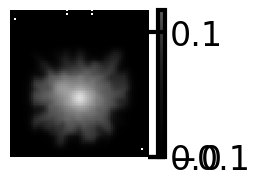

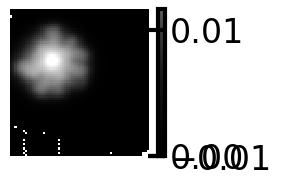

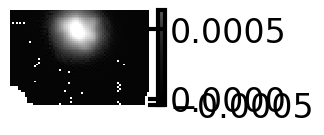

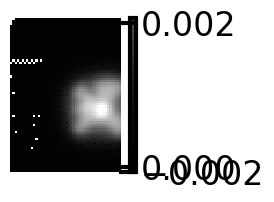

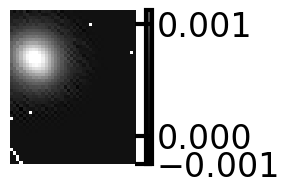

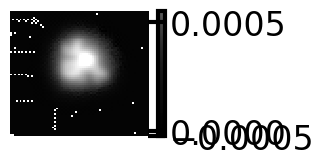

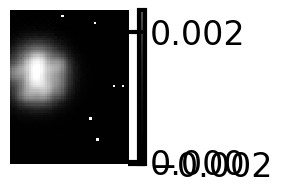

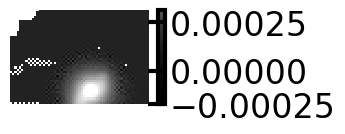

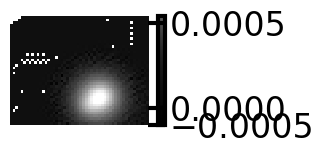

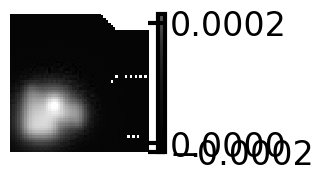

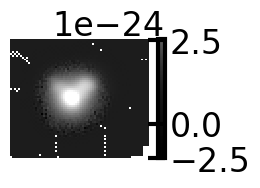

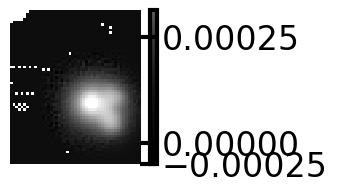

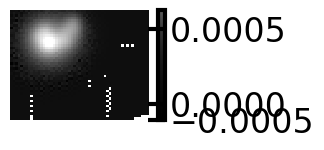

NameError: name 'cutoutSideLength' is not defined

In [14]:
# now display the footprint for each of the 13 deblended children

for i in range(len(tx)):
    dbFlux_table['footprint'][tx[i]]

    test0 = heavyFootprint2Image(dbFlux_table['footprint'][tx[i]])

    fig = plt.figure(figsize=(2, 2))
    afw_display = afwDisplay.Display(frame=fig)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(test0)
    plt.axis('off')
    plt.show()

radec = geom.SpherePoint(ra, dec, geom.degrees)
cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

# If skymap is None:
skymap = butler.get("skyMap")

# Look up the tract, patch for the RA, Dec
tractInfo = skymap.findTract(radec)
patchInfo = tractInfo.findPatch(radec)
xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
